# Cats & Dogs 전이학습(Transfer Learning)

<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/26-1.png" style="max-width: 60%; height: auto;"><p>

- Cats and Dogs dataset은 CNN 아키텍쳐를 구축하고 평가하기 위한 데이터 
- Cats and Dogs dataset은 딥러닝 학습을 위해 2,000 개의 학습 데이터와 1,000개의 테스트 데이터로 구성.
- CIFAR10 데이터의 50,000 개의 학습 데이터와 10,000개의 테스트 데이터에 비해 절대적인 데이터 개수가 부족함. 

<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/26-2.png" style="max-width: 60%; height: auto;"><p>


# Google Colab 사용

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/ML_Python')

Mounted at /content/gdrive


In [21]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 12 13:57:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              31W /  70W |  14081MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.__version__

'2.15.0'

### 파일 다운로드 (wget이 작동하지 않을때 직접 다운로드)
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
# 파일 다운로드

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-01-12 12:49:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.207, 142.250.152.207, 142.250.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  54.6MB/s    in 1.2s    

2024-01-12 12:49:25 (54.6 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# ROOT_DIR 지정
- #### ex) ROOT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/ML_Python'
- #### [os.path 사용법](https://ok-lab.tistory.com/163)

In [ ]:
import os
import shutil
ROOT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/ML_Python'

if os.path.exists(ROOT_DIR+'/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered

    shutil.rmtree(ROOT_DIR+'/cats_and_dogs_filtered/')
    print(ROOT_DIR+'/cats_and_dogs_filtered/  is removed !!!')

In [6]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile(ROOT_DIR+'/cats_and_dogs_filtered.zip', 'r') as target_file:
    target_file.extractall(ROOT_DIR+'/cats_and_dogs_filtered/')

In [7]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [23]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [24]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))    # 정답은 'cat', 'dog' 2개 이므로 node는 2개

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 16)                32784     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20894298 (79.71 MB)
Trainable params: 20839770 (79.50 MB)
Non-trainable params: 54528 (213.00 KB)
________

In [25]:
# ImageDataGenerator 이용하여 데이터 불러옴

train_data_gen = ImageDataGenerator(rescale=1./255,    # 이미지 불러올때 자동 정규화 
                                    rotation_range=10, width_shift_range=0.1,
                                    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)

test_data_gen = ImageDataGenerator(rescale=1./255)     # 이미지 불러올때 자동 정규화 

In [26]:
train_dir = ROOT_DIR+'/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
test_dir = ROOT_DIR+'/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

In [27]:
# class_mode='categorical' -> 정답은 one-hot encoding 

train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32,
                                                color_mode='rgb', shuffle=True, class_mode='categorical',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))

test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32,
                                              color_mode='rgb', shuffle=True, class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### # class_indices 속성을 이용하여 문자열로 표시되는 정답이 어떤 숫자로 매칭되는지 확인

In [28]:
# 정답 확인

print(train_data.class_indices.items())     
print(test_data.class_indices.items())

print(len(train_data.classes))
print(len(test_data.classes))

print(train_data.num_classes)
print(test_data.num_classes)

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])
2000
1000
2
2


### # Fine-tuning 에서는 learning rate를 낮게 (2e-5) 설정하여 pre-trained weight를 조금씩 업데이트함.

In [29]:
# 모델 컴파일  

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

### Model 저장 / val_loss update가 5번 (patience=5) 되지 않으면 학습 중단 / update될때마다 model 저장

In [30]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = ROOT_DIR+'/cats_and_dogs_filtered_Xception.h5'

checkpoint = ModelCheckpoint(save_file_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto'
                            )

earlystopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                             )


start_time = datetime.now()

hist = model.fit(train_data, epochs=30,
                 validation_data=test_data,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.7865
Epoch 1: val_loss improved from inf to 0.17117, saving model to /content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered_Xception.h5
63/63 [==============================] - 80s 844ms/step - loss: 0.5292 - accuracy: 0.7865 - val_loss: 0.1712 - val_accuracy: 0.9710
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9580
Epoch 2: val_loss improved from 0.17117 to 0.05788, saving model to /content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered_Xception.h5
63/63 [==============================] - 52s 816ms/step - loss: 0.2042 - accuracy: 0.9580 - val_loss: 0.0579 - val_accuracy: 0.9820
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9770
Epoch 3: val_loss improved from 0.05788 to 0.04610, saving model to /content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered_Xception.h5

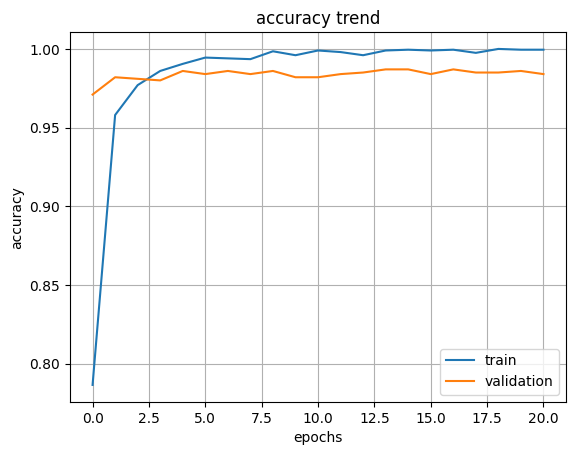

In [31]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

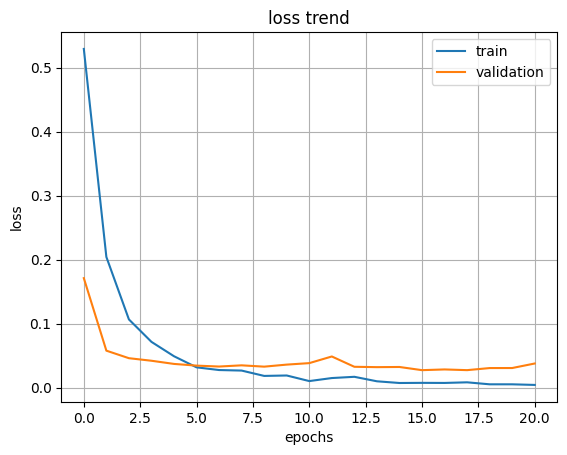

In [32]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

# Test data prediction

- #### [test image data download: [test_image_dir.zip]](http://cmseng.skku.edu/CMSLecture/ML/img/test_image_dir.zip) 

### [glob.glob() 사용법](https://tempdev.tistory.com/10)
### [BGR2RGB](https://crmn.tistory.com/49)

In [35]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob(ROOT_DIR+'/cats_and_dogs_filtered/test_image_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['/content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered/test_image_dir/test4.jpeg', '/content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered/test_image_dir/test1.png', '/content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered/test_image_dir/test5.jpg', '/content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered/test_image_dir/test3.jpg', '/content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered/test_image_dir/test2.jpg', '/content/gdrive/MyDrive/Colab Notebooks/ML_Python/cats_and_dogs_filtered/test_image_dir/test6.jpg']
6


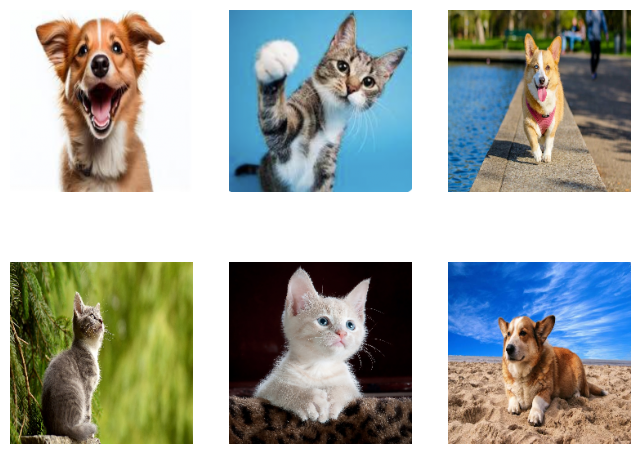

In [36]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [37]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [38]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(6, 224, 224, 3)


In [39]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)


1/1 [==============================] - 3s 3s/step
(6, 2)
[[2.22191168e-03 9.97778118e-01]
 [9.99953389e-01 4.65855082e-05]
 [6.73539995e-04 9.99326468e-01]
 [9.99889970e-01 1.10053676e-04]
 [9.99909043e-01 9.09742666e-05]
 [8.72092714e-05 9.99912739e-01]]


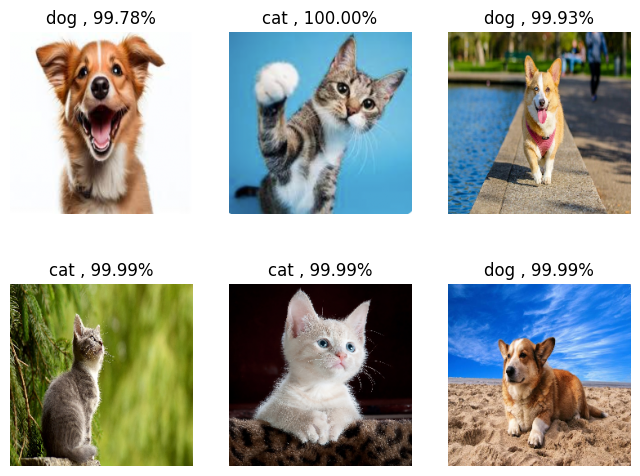

In [40]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(8,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()